<a href="https://colab.research.google.com/github/MannP7610/GNN-AnomalyDetection-/blob/main/GNN(AnomalyDetection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio torch-geometric networkx numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [35]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

df = pd.read_csv("/content/drive/MyDrive/manufacturing_test_data.csv")

In [36]:
status_mapping = {"Stopped": 0, "Running": 1}
df["M1_Status"] = df["M1_Status"].map(status_mapping)
df["M2_Status"] = df["M2_Status"].map(status_mapping)
df["M3_Status"] = df["M3_Status"].map(status_mapping)

# Create graph structure
G = nx.Graph()
machines = ["M1", "M2", "M3"]


In [37]:
for machine in machines:
    G.add_node(machine)

G.add_edge("M1", "M2")
G.add_edge("M2", "M3")
G.add_edge("M3", "M1")

node_map = {machine: i for i, machine in enumerate(machines)}
edge_index = torch.tensor([[node_map[u], node_map[v]] for u, v in G.edges()], dtype=torch.long).t().contiguous()

In [38]:
num_samples = len(df)
features = np.zeros((num_samples, len(machines) * 2))

for i, row in df.iterrows():
    features[i] = [
        row["M1_Status"], row["M1_Worker_Count"],
        row["M2_Status"], row["M2_Worker_Count"],
        row["M3_Status"], row["M3_Worker_Count"]
    ]

x = torch.tensor(features, dtype=torch.float)

In [39]:
class GCNAnomalyDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNAnomalyDetector, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [40]:
input_dim = x.shape[1]
hidden_dim = 16
output_dim = input_dim
model = GCNAnomalyDetector(input_dim, hidden_dim, output_dim)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

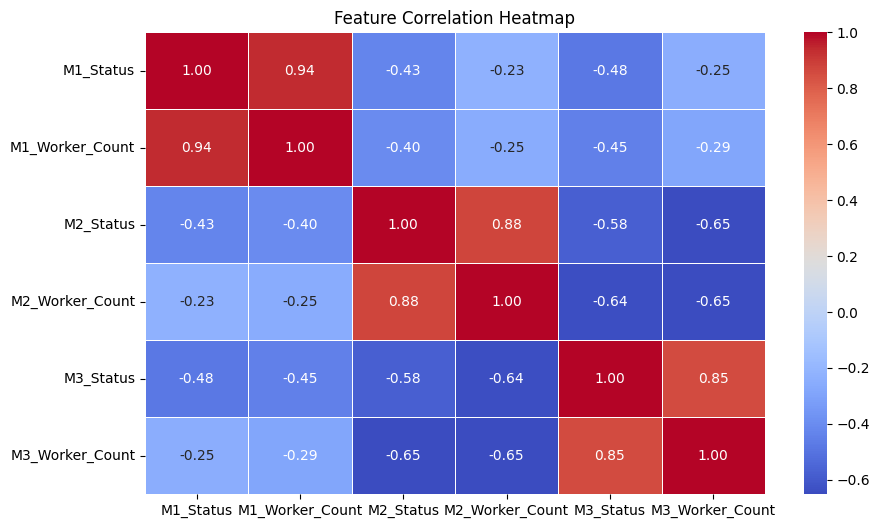

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_correlation(df):
    """Heatmap to visualize correlation between numerical variables only"""

    # Select only numeric columns
    numeric_df = df.select_dtypes(include=["number"])

    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.show()

# Call function again
plot_feature_correlation(df)


In [50]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x, edge_index)
    loss = criterion(output, x)
    loss.backward()
    optimizer.step()

print("Training Completed!")

Training Completed!


In [51]:
model.eval()
with torch.no_grad():
    reconstructed = model(x, edge_index)
    anomaly_scores = torch.mean((reconstructed - x) ** 2, dim=1).numpy()

threshold = np.percentile(anomaly_scores, 95)
all_anomalies = anomaly_scores > threshold

m3_to_m1_cases = ((df["M1_Status"] == 1) & (df["M3_Status"] == 1)).to_numpy()
true_anomalies = np.logical_and(all_anomalies, ~m3_to_m1_cases)

print(f"Total anomalies detected: {np.sum(all_anomalies)}")
print(f"Final anomalies (excluding M3→M1 cases): {np.sum(true_anomalies)}")

Total anomalies detected: 13
Final anomalies (excluding M3→M1 cases): 13
